In [1]:
import numpy as np
import pandas as pd
import chardet
import matplotlib.pyplot as plt
import nltk
from nltk.tokenize import word_tokenize, sent_tokenize
import seaborn as sns

In [2]:
with open('spam.csv', 'rb') as rawdata:
    result = chardet.detect(rawdata.read(100000))
result

{'encoding': 'Windows-1252', 'confidence': 0.7270322499829184, 'language': ''}

In [3]:
df = pd.read_csv('spam.csv',encoding='Windows-1252')

In [4]:
df = df[['v1','v2']]

In [5]:
df.columns = ['label','text']

In [6]:
df.head()

,label,text
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [7]:
df['label'].value_counts()

ham     4825
spam     747
Name: label, dtype: int64

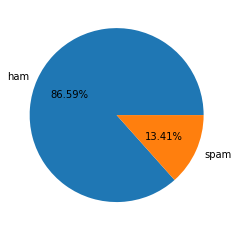

In [8]:
## Pie Chart of the labels

plt.pie(df['label'].value_counts(),labels=['ham','spam'],autopct='%0.2f%%')
plt.show()

## Creating New Features

In [9]:
df['num_char'] = df['text'].apply(len)

In [10]:
df['num_words'] = (df['text'].apply(word_tokenize)).apply(len)

In [11]:
df['num_sentences'] = (df['text'].apply(sent_tokenize)).apply(len)

In [12]:
df.head()

,label,text,num_char,num_words,num_sentences
0,ham,"Go until jurong point, crazy.. Available only ...",111,24,2
1,ham,Ok lar... Joking wif u oni...,29,8,2
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,155,37,2
3,ham,U dun say so early hor... U c already then say...,49,13,1
4,ham,"Nah I don't think he goes to usf, he lives aro...",61,15,1


### Analyzing New Features For different Labels

In [13]:
df[df['label']=='ham'].describe()

,num_char,num_words,num_sentences
count,4825.000000,4825.000000,4825.000000
mean,71.023627,17.271917,1.808705
std,58.016023,13.988885,1.328227
min,2.000000,1.000000,1.000000
25%,33.000000,8.000000,1.000000
50%,52.000000,13.000000,1.000000
75%,92.000000,22.000000,2.000000
max,910.000000,220.000000,28.000000


In [14]:
df[df['label']=='spam'].describe()

,num_char,num_words,num_sentences
count,747.000000,747.000000,747.000000
mean,138.866131,27.891566,3.017403
std,29.183082,6.867007,1.528449
min,13.000000,2.000000,1.000000
25%,132.500000,25.000000,2.000000
50%,149.000000,29.000000,3.000000
75%,157.000000,32.000000,4.000000
max,224.000000,46.000000,8.000000


#### Observations
- We observer that spam messages have more sentences, more words and more characters on average.
- There are some outliers in ham messages.

### Data Visualization

<AxesSubplot:>

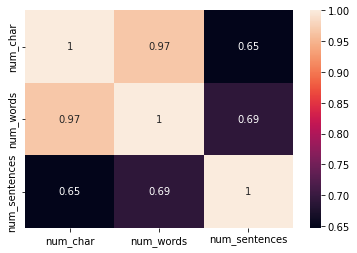

In [15]:
sns.heatmap(df.corr(),annot=True)

#### Observation
- All those features have a high correlation. So, there might be a linear dependency between the features.
- So, we will use exactly one feature(num_char) out of these 3 featrues for further analysis.

In [16]:
df = df[['label','text','num_char']]
df.head()

,label,text,num_char
0,ham,"Go until jurong point, crazy.. Available only ...",111
1,ham,Ok lar... Joking wif u oni...,29
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,155
3,ham,U dun say so early hor... U c already then say...,49
4,ham,"Nah I don't think he goes to usf, he lives aro...",61


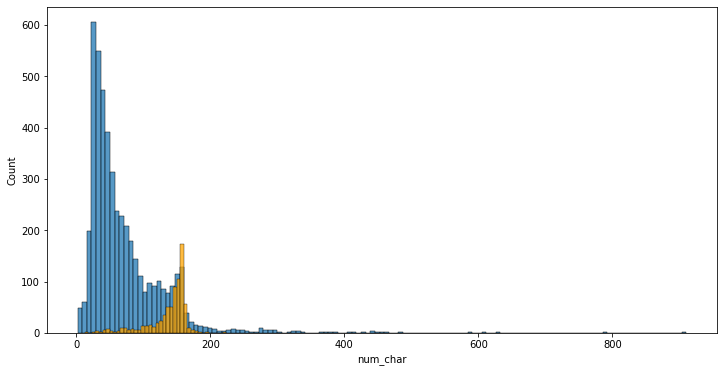

In [17]:
plt.figure(figsize=(12,6))
sns.histplot(df[df['label'] == 'ham']['num_char'])
sns.histplot(df[df['label'] == 'spam']['num_char'],color='orange') 
plt.show()

### Wrod Cloud

In [18]:
from wordcloud import WordCloud
wc = WordCloud(width=500,height=500,min_font_size=10,background_color='white')

In [19]:
spam_wc = wc.generate(df[df['label'] == 'spam']['text'].str.cat(sep=" "))

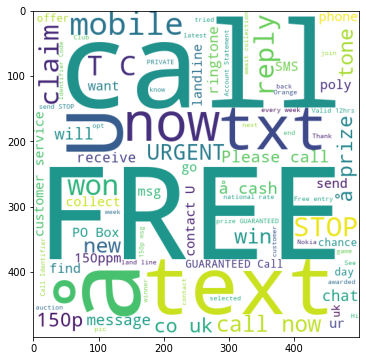

In [20]:
plt.figure(figsize=(15,6))
plt.imshow(spam_wc)

#### Obsrevation
- Most of the spam messages contains terms like free, call, won, text etc. which is true in general

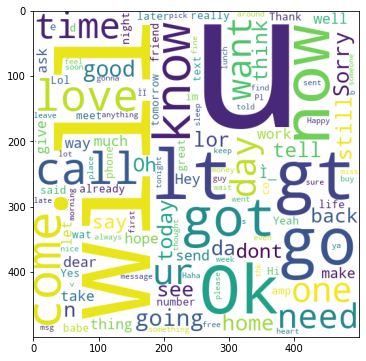

In [21]:
ham_wc = wc.generate(df[df['label'] == 'ham']['text'].str.cat(sep=" "))
plt.figure(figsize=(15,6))
plt.imshow(ham_wc)

### Data Preprocessing
- Lower the text
- Remove punctuations like ".","!" etc.
- Remove stopwords
- Apply stemming

In [22]:
def text_preprocessing(text):
    from nltk.tokenize import word_tokenize
    from nltk.stem.porter import PorterStemmer
    import string
    from nltk.corpus import stopwords
    text = text.lower()
    
    for punc in string.punctuation:
        text = text.replace(punc,'')
    
    text_list = word_tokenize(text)
    
    for word in text_list:
        if word in stopwords.words('english'):
            text_list.remove(word)
    ps = PorterStemmer()
    
    for index in range(len(text_list)):
        text_list[index] = ps.stem(text_list[index])
        
    return ' '.join(text_list)
    

In [23]:
## Applying data preprocessing

df['text'] = df['text'].apply(text_preprocessing)

In [24]:
df['label'] = df['label'].replace({'spam':1 , 'ham':0})
df.head()

,label,text,num_char
0,0,go jurong point crazi avail in bugi n great wo...,111
1,0,ok lar joke wif u oni,29
2,1,free entri 2 wkli comp win fa cup final tkt 21...,155
3,0,u dun say earli hor u c alreadi say,49
4,0,nah dont think goe usf live around though,61


### Word Vectorization
- Represents Words as vectors

In [25]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split

X = df['text'].values
y = df['label'].values

X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2)

tfidf = TfidfVectorizer(max_features=3000)

# print(X_train)
X_train = tfidf.fit_transform(X_train).toarray()

X_test = tfidf.transform(X_test).toarray()
print(X_train.shape)

(4457, 3000)


### Training Different Machine Learning Models 

In [26]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB,BernoulliNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier

In [27]:
lr = LogisticRegression()
svc = SVC()
mnb = MultinomialNB()
bnb = BernoulliNB()
dc = DecisionTreeClassifier()
knc = KNeighborsClassifier()
rfc = RandomForestClassifier(n_estimators=100,random_state=2)
abc = AdaBoostClassifier(n_estimators=100,random_state=2)
bc = BaggingClassifier(n_estimators=100,random_state=2)
etc = ExtraTreesClassifier(n_estimators=100,random_state=2)
gbc = GradientBoostingClassifier(n_estimators=100,random_state=2)
xgb = XGBClassifier(n_estimators=100,random_state=2)

In [28]:
## Classifier's Dictionary
clf_dict = {
    'Logistic Regression':lr,
    'Support Vector Classifier':svc,
    'Multinomial NB':mnb,
    'Beronuli NB':bnb,
    'Decesion Tree':dc,
    'K neghibours':knc,
    'Random Forest':rfc,
    'AdaBoost':abc,
    'Bagging':bc,
    'Extra Tree':etc,
    'Gradient Boost':gbc,
    'XGB':xgb
}


In [29]:
from sklearn.metrics import accuracy_score,confusion_matrix,precision_score

def train_model(clf,X_train,y_train,X_test,y_test):
    clf.fit(X_train,y_train)
    y_pred = clf.predict(X_test)
    accuracy = accuracy_score(y_test,y_pred)
    precision = precision_score(y_test,y_pred)
    
    return clf,accuracy,precision

In [30]:
accuracy_scores = []
precision_scores = []

for clf in clf_dict.keys():
    _,accuracy,precision = train_model(clf_dict[clf],X_train,y_train,X_test,y_test)
    accuracy_scores.append(accuracy)
    precision_scores.append(precision)
    print(f'{clf} - Accuracy: {accuracy}, Precision: {precision}')

Logistic Regression - Accuracy: 0.9704035874439462, Precision: 0.9797979797979798
Support Vector Classifier - Accuracy: 0.9775784753363229, Precision: 0.9904761904761905
Multinomial NB - Accuracy: 0.9739910313901345, Precision: 0.9900990099009901
Beronuli NB - Accuracy: 0.9820627802690582, Precision: 0.990909090909091
Decesion Tree - Accuracy: 0.9587443946188341, Precision: 0.8153846153846154
K neghibours - Accuracy: 0.9291479820627803, Precision: 1.0
Random Forest - Accuracy: 0.9811659192825112, Precision: 0.9908256880733946
AdaBoost - Accuracy: 0.9748878923766816, Precision: 0.923728813559322
Bagging - Accuracy: 0.9775784753363229, Precision: 0.9256198347107438
Extra Tree - Accuracy: 0.9820627802690582, Precision: 0.990909090909091
Gradient Boost - Accuracy: 0.9721973094170404, Precision: 0.98989898989899
XGB - Accuracy: 0.9856502242152466, Precision: 0.9912280701754386


In [31]:
performance = pd.DataFrame({'Model':clf_dict.keys(),'Accuracy':accuracy_scores,'Precision':precision_scores}).sort_values(by='Precision',ascending=False)

### Performance Of Different Models

In [32]:
performance

,Model,Accuracy,Precision
5,K neghibours,0.929148,1.000000
11,XGB,0.985650,0.991228
3,Beronuli NB,0.982063,0.990909
9,Extra Tree,0.982063,0.990909
6,Random Forest,0.981166,0.990826
1,Support Vector Classifier,0.977578,0.990476
2,Multinomial NB,0.973991,0.990099
10,Gradient Boost,0.972197,0.989899
0,Logistic Regression,0.970404,0.979798
8,Bagging,0.977578,0.925620


#### Comment
- Here, precision is more important than the peformance as we don't want a ham message to classified as spam.
- Among all models Multinomial Naive Bayes has highest accuracy with maximum precision.
- We will consider Multinomial Naive Bayes model for deployment

In [33]:
import pickle

clf,_,_ = train_model(clf_dict['Multinomial NB'],X_train,y_train,X_test,y_test)

In [34]:
pickle.dump(tfidf,open('vectorizer.pkl','wb'))
pickle.dump(clf,open('model.pkl','wb'))